In [1]:
import pandas as pd
import numpy as np
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
from string import punctuation
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
import multiprocessing

In [2]:
tf.__version__

'2.2.0'

In [3]:
keras.__version__

'2.3.0-tf'

In [4]:
if tf.__version__.startswith("1."):
    val_acc_name = "val_acc"
    acc_name = "acc"
else:
    val_acc_name = "val_accuracy"
    acc_name = "accuracy"

In [5]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to /home/bocharick/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
max_words = 2000
max_len = 50

# Training
epochs = 150
batch_size = 512

In [7]:
sw = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

In [8]:
def preprocess_text(txt):
    txt = str(txt)
    txt = re.sub(r'( )+', " ", re.sub(r'[^\w\s]', " ", txt)).strip()
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    txt = " ".join(txt)
    txt = re.sub("\sне", "не", txt)
    return txt

In [9]:
otzivy_za_leto = pd.read_excel("отзывы за лето.xls", )

In [10]:
otzivy_za_leto.head()

,Rating,Content,Date
0,5,It just works!,2017-08-14
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14
2,5,Отлично все,2017-08-14
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14
4,5,"Очень удобно, работает быстро.",2017-08-14


In [11]:
text111 = otzivy_za_leto.iloc[12]["Content"]
print(text111)
preprocessed_text111 = preprocess_text(text111)
print(type(preprocessed_text111))
print(preprocessed_text111)

Не стартует без доступа к gps, sms, звонкам и адресной книге. Филиал фсб одним словом
<class 'str'>
стартовать доступ gps sms звонок адресный книга филиал фсб один слово


In [12]:
otzivy_za_leto.Rating.unique()

array([5, 4, 2, 3, 1])

In [13]:
# for to_categorical usage
otzivy_za_leto.Rating = otzivy_za_leto.Rating - 1

In [14]:
otzivy_za_leto.head()

,Rating,Content,Date
0,4,It just works!,2017-08-14
1,3,В целом удобноное приложение...из минусов хотя...,2017-08-14
2,4,Отлично все,2017-08-14
3,4,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14
4,4,"Очень удобно, работает быстро.",2017-08-14


In [15]:
otzivy_za_leto.Rating.unique()

array([4, 3, 1, 2, 0])

In [16]:
vfunc = np.vectorize(preprocess_text)

In [17]:
%%time
otzivy_za_leto["text"] = vfunc(otzivy_za_leto.Content)
otzivy_za_leto.head()

CPU times: user 9.45 s, sys: 42.2 ms, total: 9.5 s
Wall time: 9.5 s


,Rating,Content,Date,text
0,4,It just works!,2017-08-14,it just works
1,3,В целом удобноное приложение...из минусов хотя...,2017-08-14,целое удобноной приложение минус хотеть большо...
2,4,Отлично все,2017-08-14,отлично
3,4,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14,зависать 1 работа антивирус ранее пользоваться...
4,4,"Очень удобно, работает быстро.",2017-08-14,удобно работать быстро


In [18]:
train_corpus = " ".join(otzivy_za_leto["text"])
train_corpus = train_corpus.lower()

In [19]:
tokens = word_tokenize(train_corpus)

In [20]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [21]:
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]

In [22]:
tokens_filtered_top[:20]

['приложение',
 'удобно',
 'работать',
 'удобный',
 'отлично',
 'нравиться',
 'хороший',
 'телефон',
 'отличный',
 'супер',
 'обновление',
 'быстро',
 'пароль',
 'пользоваться',
 'мочь',
 'антивирус',
 'сбербанк',
 'раз',
 'устраивать',
 'вход']

In [23]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [24]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

In [25]:
x_train = np.asarray([text_to_sequence(text, max_len) for text in otzivy_za_leto["text"]], dtype=np.int32)

In [26]:
x_train[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,   96,    1,  124,  172,   93,   69, 1357,
        868,    8,   35,   14,  375,  445], dtype=int32)

In [27]:
otzivy_za_leto["Rating"].unique()

array([4, 3, 1, 2, 0])

In [28]:
num_classes = len(otzivy_za_leto["Rating"].unique())
num_classes

5

In [29]:
y_train = keras.utils.to_categorical(otzivy_za_leto["Rating"], num_classes)

In [30]:
keras.backend.clear_session()

embed_vec_len = 50

X_input = tf.keras.layers.Input(shape=(max_len,), name="X")
Embed_ = tf.keras.layers.Embedding(input_dim=max_words, output_dim=embed_vec_len, name="Embed_")(X_input)
Conv1_ = tf.keras.layers.Conv1D(filters=embed_vec_len*10, kernel_size=5, activation="relu", name="Conv1_")(Embed_)
GlobMaxPool1_ = tf.keras.layers.GlobalMaxPool1D(name="GlobMaxPool1")(Conv1_)
Drop1_ = tf.keras.layers.Dropout(0.6)(GlobMaxPool1_)
Dense1_ = tf.keras.layers.Dense(32, activation="relu", name="Dense1_")(Drop1_)
Drop2_ = tf.keras.layers.Dropout(0.6)(Dense1_)
Dense2_ = tf.keras.layers.Dense(32, activation="relu", name="Dense2_")(Drop2_)
Drop3_ = tf.keras.layers.Dropout(0.6)(Dense2_)
Dense3_ = tf.keras.layers.Dense(32, activation="relu", name="Dense3_")(Drop3_)
Drop4_ = tf.keras.layers.Dropout(0.6)(Dense3_)
Dense4_ = tf.keras.layers.Dense(32, activation="relu", name="Dense4_")(Drop4_)
Drop5_ = tf.keras.layers.Dropout(0.75)(Dense4_)
y_output = tf.keras.layers.Dense(num_classes, activation="softmax", name="y")(Drop5_)

model = tf.keras.models.Model(inputs=[X_input], outputs=[y_output], name="my_model")
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [31]:
# keras.backend.clear_session()

# embed_vec_len = 50

# X_input = tf.keras.layers.Input(shape=(max_len,), name="X")
# Embed_ = tf.keras.layers.Embedding(input_dim=max_words, output_dim=embed_vec_len, name="Embed_")(X_input)
# Conv1_ = tf.keras.layers.Conv1D(filters=embed_vec_len, kernel_size=3, activation="elu", name="Conv1_")(Embed_)
# BatchNorm1 = tf.keras.layers.BatchNormalization()(Conv1_)
# Conv2_ = tf.keras.layers.Conv1D(filters=embed_vec_len, kernel_size=3, activation="elu", name="Conv2_")(BatchNorm1)
# BatchNorm2 = tf.keras.layers.BatchNormalization()(Conv2_)
# MaxPool1 = tf.keras.layers.MaxPool1D(pool_size=2, strides=1, padding='same')(BatchNorm2)
# Drop1_ = tf.keras.layers.Dropout(0.2)(MaxPool1)

# Flat1_ = tf.keras.layers.Flatten(name="Flatten_1")(Drop1_)
# Dense1_ = tf.keras.layers.Dense(units=256, activation="relu", name="Dense_1")(Flat1_)
# Dense2_ = tf.keras.layers.Dense(units=num_classes, activation=None, name="Dense_2")(Dense1_)

# model = tf.keras.models.Model(inputs=[X_input], outputs=[Dense2_], name="my_model")
# model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

In [32]:
model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X (InputLayer)               [(None, 50)]              0         
_________________________________________________________________
Embed_ (Embedding)           (None, 50, 50)            100000    
_________________________________________________________________
Conv1_ (Conv1D)              (None, 46, 500)           125500    
_________________________________________________________________
GlobMaxPool1 (GlobalMaxPooli (None, 500)               0         
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
Dense1_ (Dense)              (None, 32)                16032     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0  

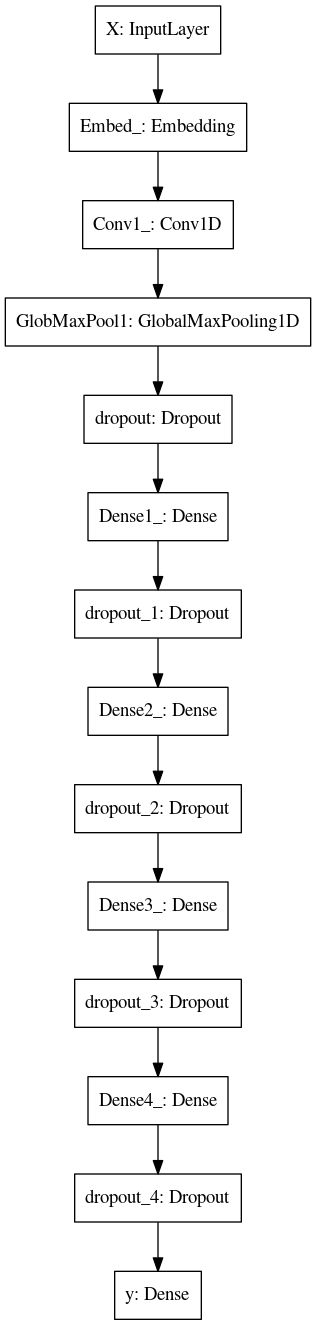

In [33]:
tf.keras.utils.plot_model(model)

In [34]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2,
                    )

Epoch 1/150
33/33 [==============================] - 1s 26ms/step - loss: 1.4549 - accuracy: 0.4600 - val_loss: 1.2733 - val_accuracy: 0.6227
Epoch 2/150
33/33 [==============================] - 1s 16ms/step - loss: 1.1881 - accuracy: 0.6729 - val_loss: 1.0296 - val_accuracy: 0.6227
Epoch 3/150
33/33 [==============================] - 1s 17ms/step - loss: 0.9974 - accuracy: 0.7082 - val_loss: 0.9115 - val_accuracy: 0.6227
Epoch 4/150
33/33 [==============================] - 1s 17ms/step - loss: 0.8955 - accuracy: 0.7171 - val_loss: 0.8977 - val_accuracy: 0.6227
Epoch 5/150
33/33 [==============================] - 1s 17ms/step - loss: 0.8417 - accuracy: 0.7223 - val_loss: 0.8764 - val_accuracy: 0.6227
Epoch 6/150
33/33 [==============================] - 1s 17ms/step - loss: 0.7979 - accuracy: 0.7243 - val_loss: 0.8702 - val_accuracy: 0.6227
Epoch 7/150
33/33 [==============================] - 1s 18ms/step - loss: 0.7632 - accuracy: 0.7247 - val_loss: 0.8698 - val_accuracy: 0.6227
Epoch 

33/33 [==============================] - 1s 17ms/step - loss: 0.6056 - accuracy: 0.7898 - val_loss: 1.2306 - val_accuracy: 0.7345
Epoch 59/150
33/33 [==============================] - 1s 17ms/step - loss: 0.6051 - accuracy: 0.7888 - val_loss: 1.1877 - val_accuracy: 0.7318
Epoch 60/150
33/33 [==============================] - 1s 17ms/step - loss: 0.5981 - accuracy: 0.7897 - val_loss: 1.2277 - val_accuracy: 0.7340
Epoch 61/150
33/33 [==============================] - 1s 18ms/step - loss: 0.6031 - accuracy: 0.7899 - val_loss: 1.3445 - val_accuracy: 0.7398
Epoch 62/150
33/33 [==============================] - 1s 17ms/step - loss: 0.6026 - accuracy: 0.7905 - val_loss: 1.1773 - val_accuracy: 0.7355
Epoch 63/150
33/33 [==============================] - 1s 17ms/step - loss: 0.6085 - accuracy: 0.7897 - val_loss: 1.2329 - val_accuracy: 0.7348
Epoch 64/150
33/33 [==============================] - 1s 17ms/step - loss: 0.6015 - accuracy: 0.7903 - val_loss: 1.1871 - val_accuracy: 0.7314
Epoch 65/150

33/33 [==============================] - 1s 17ms/step - loss: 0.5753 - accuracy: 0.7939 - val_loss: 1.4929 - val_accuracy: 0.7355
Epoch 116/150
33/33 [==============================] - 1s 18ms/step - loss: 0.5797 - accuracy: 0.7940 - val_loss: 1.4999 - val_accuracy: 0.7379
Epoch 117/150
33/33 [==============================] - 1s 17ms/step - loss: 0.5823 - accuracy: 0.7929 - val_loss: 1.4769 - val_accuracy: 0.7379
Epoch 118/150
33/33 [==============================] - 1s 17ms/step - loss: 0.5803 - accuracy: 0.7932 - val_loss: 1.4650 - val_accuracy: 0.7389
Epoch 119/150
33/33 [==============================] - 1s 17ms/step - loss: 0.5759 - accuracy: 0.7945 - val_loss: 1.6221 - val_accuracy: 0.7389
Epoch 120/150
33/33 [==============================] - 1s 18ms/step - loss: 0.5819 - accuracy: 0.7936 - val_loss: 1.5017 - val_accuracy: 0.7343
Epoch 121/150
33/33 [==============================] - 1s 17ms/step - loss: 0.5809 - accuracy: 0.7931 - val_loss: 1.6388 - val_accuracy: 0.7357
Epoch 

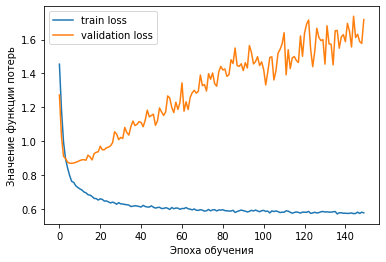

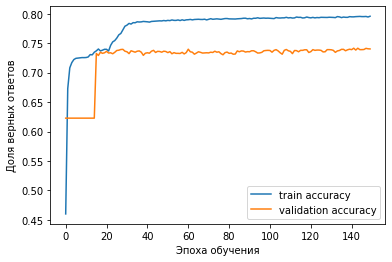

In [35]:
plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение функции потерь')
plt.legend()

plt.figure()
plt.plot(history.history[acc_name], label='train accuracy')
plt.plot(history.history[val_acc_name], label='validation accuracy')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()

plt.show()

### Попробуем натренировать Word2Vec и использовать полученные веса в качестве инициализации Embedding векторов

In [36]:
sentences_list_of_lists = [[sentence] for sentence in otzivy_za_leto.text.tolist()]
sentences_list_of_lists[:10]

[['it just works'],
 ['целое удобноной приложение минус хотеть большой доступ персональный данные телефон приходиться пользоваться ограниченный режим'],
 ['отлично'],
 ['зависать 1 работа антивирус ранее пользоваться нормальный'],
 ['удобно работать быстро'],
 ['удобно норма'],
 ['удобный приложение'],
 ['устраивать'],
 ['работать чётко отличие банкомат вечно зависать тупить'],
 ['']]

In [37]:
modelW2V = Word2Vec(sentences=sentences_list_of_lists, size=embed_vec_len, window=10, min_count=2, workers=multiprocessing.cpu_count())

In [38]:
buffer = np.random.random((max_words,embed_vec_len))
buffer

array([[1.28180397e-01, 2.14206863e-02, 3.78046068e-01, ...,
        6.09205784e-01, 7.76208587e-01, 1.92400031e-01],
       [4.72763195e-01, 7.89878739e-01, 2.04506325e-01, ...,
        5.32424943e-01, 2.94428782e-01, 8.32505819e-01],
       [6.77017267e-01, 3.36482268e-01, 8.23057880e-01, ...,
        6.94950972e-01, 8.17474482e-01, 3.64382825e-01],
       ...,
       [1.75575103e-01, 3.98010550e-01, 5.22724741e-01, ...,
        1.81129892e-01, 5.99292916e-02, 2.72317446e-01],
       [1.54496629e-04, 1.80070631e-01, 1.33471532e-01, ...,
        5.43158742e-01, 5.34319786e-02, 4.95512384e-01],
       [9.06591235e-01, 9.12535959e-01, 2.06641158e-01, ...,
        4.30576519e-01, 3.46851346e-01, 9.65238506e-01]])

In [39]:
for word in vocabulary:
    if word in modelW2V.wv:
#         print(word, modelW2V.wv[word])
        buffer[vocabulary[word]] = modelW2V.wv[word]

### Зафиксированные Embedding-и после инициализации

In [40]:
keras.backend.clear_session()

X_input = tf.keras.layers.Input(shape=(max_len,), name="X")
Embed_ = tf.keras.layers.Embedding(input_dim=max_words, output_dim=embed_vec_len, name="Embed_", weights=[buffer], trainable=False)(X_input)
Conv1_ = tf.keras.layers.Conv1D(filters=embed_vec_len, kernel_size=5, activation="relu", name="Conv1_")(Embed_)
GlobMaxPool1_ = tf.keras.layers.GlobalMaxPool1D(name="GlobMaxPool1")(Conv1_)
Drop1_ = tf.keras.layers.Dropout(0.6)(GlobMaxPool1_)
Dense1_ = tf.keras.layers.Dense(32, activation="relu", name="Dense1_")(Drop1_)
Drop2_ = tf.keras.layers.Dropout(0.6)(Dense1_)
Dense2_ = tf.keras.layers.Dense(32, activation="relu", name="Dense2_")(Drop2_)
Drop3_ = tf.keras.layers.Dropout(0.6)(Dense2_)
Dense3_ = tf.keras.layers.Dense(32, activation="relu", name="Dense3_")(Drop3_)
Drop4_ = tf.keras.layers.Dropout(0.6)(Dense3_)
Dense4_ = tf.keras.layers.Dense(32, activation="relu", name="Dense4_")(Drop4_)
Drop5_ = tf.keras.layers.Dropout(0.75)(Dense4_)
y_output = tf.keras.layers.Dense(num_classes, activation="softmax", name="y")(Drop5_)

model = tf.keras.models.Model(inputs=[X_input], outputs=[y_output], name="my_model")
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [41]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2,
                    )

Epoch 1/150
33/33 [==============================] - 0s 7ms/step - loss: 1.6269 - accuracy: 0.4470 - val_loss: 1.4580 - val_accuracy: 0.6227
Epoch 2/150
33/33 [==============================] - 0s 4ms/step - loss: 1.2951 - accuracy: 0.6364 - val_loss: 1.2632 - val_accuracy: 0.6227
Epoch 3/150
33/33 [==============================] - 0s 4ms/step - loss: 1.1582 - accuracy: 0.6996 - val_loss: 1.1679 - val_accuracy: 0.6227
Epoch 4/150
33/33 [==============================] - 0s 4ms/step - loss: 1.0790 - accuracy: 0.7178 - val_loss: 1.1252 - val_accuracy: 0.6227
Epoch 5/150
33/33 [==============================] - 0s 4ms/step - loss: 1.0381 - accuracy: 0.7222 - val_loss: 1.1092 - val_accuracy: 0.6227
Epoch 6/150
33/33 [==============================] - 0s 4ms/step - loss: 1.0106 - accuracy: 0.7244 - val_loss: 1.1124 - val_accuracy: 0.6227
Epoch 7/150
33/33 [==============================] - 0s 4ms/step - loss: 0.9994 - accuracy: 0.7254 - val_loss: 1.1061 - val_accuracy: 0.6227
Epoch 8/150
3

Epoch 59/150
33/33 [==============================] - 0s 4ms/step - loss: 0.8527 - accuracy: 0.7269 - val_loss: 0.9774 - val_accuracy: 0.6227
Epoch 60/150
33/33 [==============================] - 0s 4ms/step - loss: 0.8518 - accuracy: 0.7268 - val_loss: 0.9752 - val_accuracy: 0.6227
Epoch 61/150
33/33 [==============================] - 0s 4ms/step - loss: 0.8423 - accuracy: 0.7269 - val_loss: 0.9706 - val_accuracy: 0.6227
Epoch 62/150
33/33 [==============================] - 0s 4ms/step - loss: 0.8462 - accuracy: 0.7269 - val_loss: 0.9747 - val_accuracy: 0.6227
Epoch 63/150
33/33 [==============================] - 0s 4ms/step - loss: 0.8497 - accuracy: 0.7271 - val_loss: 0.9789 - val_accuracy: 0.6227
Epoch 64/150
33/33 [==============================] - 0s 4ms/step - loss: 0.8451 - accuracy: 0.7270 - val_loss: 0.9772 - val_accuracy: 0.6227
Epoch 65/150
33/33 [==============================] - 0s 4ms/step - loss: 0.8446 - accuracy: 0.7268 - val_loss: 0.9847 - val_accuracy: 0.6227
Epoch 

33/33 [==============================] - 0s 4ms/step - loss: 0.8175 - accuracy: 0.7267 - val_loss: 0.9448 - val_accuracy: 0.6227
Epoch 117/150
33/33 [==============================] - 0s 4ms/step - loss: 0.8145 - accuracy: 0.7258 - val_loss: 0.9392 - val_accuracy: 0.6227
Epoch 118/150
33/33 [==============================] - 0s 4ms/step - loss: 0.8169 - accuracy: 0.7270 - val_loss: 0.9353 - val_accuracy: 0.6227
Epoch 119/150
33/33 [==============================] - 0s 4ms/step - loss: 0.8127 - accuracy: 0.7277 - val_loss: 0.9393 - val_accuracy: 0.6227
Epoch 120/150
33/33 [==============================] - 0s 4ms/step - loss: 0.8140 - accuracy: 0.7276 - val_loss: 0.9430 - val_accuracy: 0.6227
Epoch 121/150
33/33 [==============================] - 0s 4ms/step - loss: 0.8146 - accuracy: 0.7285 - val_loss: 0.9407 - val_accuracy: 0.6227
Epoch 122/150
33/33 [==============================] - 0s 4ms/step - loss: 0.8184 - accuracy: 0.7268 - val_loss: 0.9453 - val_accuracy: 0.6227
Epoch 123/150

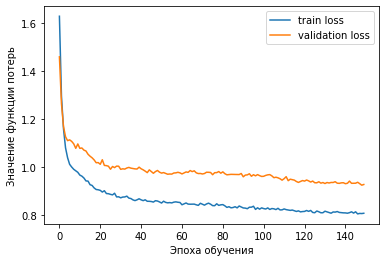

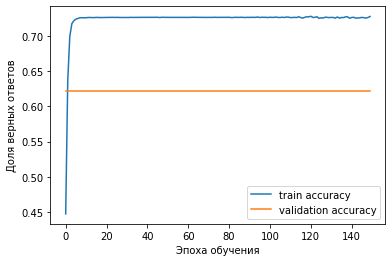

In [42]:
plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение функции потерь')
plt.legend()

plt.figure()
plt.plot(history.history[acc_name], label='train accuracy')
plt.plot(history.history[val_acc_name], label='validation accuracy')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()

plt.show()

### Embedding-и дотренировываются после инициализации

In [43]:
keras.backend.clear_session()

X_input = tf.keras.layers.Input(shape=(max_len,), name="X")
Embed_ = tf.keras.layers.Embedding(input_dim=max_words, output_dim=embed_vec_len, name="Embed_", weights=[buffer], trainable=True)(X_input)
Conv1_ = tf.keras.layers.Conv1D(filters=embed_vec_len, kernel_size=5, activation="relu", name="Conv1_")(Embed_)
GlobMaxPool1_ = tf.keras.layers.GlobalMaxPool1D(name="GlobMaxPool1")(Conv1_)
Drop1_ = tf.keras.layers.Dropout(0.6)(GlobMaxPool1_)
Dense1_ = tf.keras.layers.Dense(32, activation="relu", name="Dense1_")(Drop1_)
Drop2_ = tf.keras.layers.Dropout(0.6)(Dense1_)
Dense2_ = tf.keras.layers.Dense(32, activation="relu", name="Dense2_")(Drop2_)
Drop3_ = tf.keras.layers.Dropout(0.6)(Dense2_)
Dense3_ = tf.keras.layers.Dense(32, activation="relu", name="Dense3_")(Drop3_)
Drop4_ = tf.keras.layers.Dropout(0.6)(Dense3_)
Dense4_ = tf.keras.layers.Dense(32, activation="relu", name="Dense4_")(Drop4_)
Drop5_ = tf.keras.layers.Dropout(0.75)(Dense4_)
y_output = tf.keras.layers.Dense(num_classes, activation="softmax", name="y")(Drop5_)

model = tf.keras.models.Model(inputs=[X_input], outputs=[y_output], name="my_model")
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [44]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2,
                    )

Epoch 1/150
33/33 [==============================] - 0s 10ms/step - loss: 1.6156 - accuracy: 0.4607 - val_loss: 1.4719 - val_accuracy: 0.6227
Epoch 2/150
33/33 [==============================] - 0s 6ms/step - loss: 1.3207 - accuracy: 0.6416 - val_loss: 1.2627 - val_accuracy: 0.6227
Epoch 3/150
33/33 [==============================] - 0s 6ms/step - loss: 1.1656 - accuracy: 0.7135 - val_loss: 1.1501 - val_accuracy: 0.6227
Epoch 4/150
33/33 [==============================] - 0s 5ms/step - loss: 1.1051 - accuracy: 0.7233 - val_loss: 1.1225 - val_accuracy: 0.6227
Epoch 5/150
33/33 [==============================] - 0s 6ms/step - loss: 1.0580 - accuracy: 0.7249 - val_loss: 1.1035 - val_accuracy: 0.6227
Epoch 6/150
33/33 [==============================] - 0s 6ms/step - loss: 1.0414 - accuracy: 0.7261 - val_loss: 1.0895 - val_accuracy: 0.6227
Epoch 7/150
33/33 [==============================] - 0s 6ms/step - loss: 1.0163 - accuracy: 0.7261 - val_loss: 1.0744 - val_accuracy: 0.6227
Epoch 8/150


Epoch 59/150
33/33 [==============================] - 0s 6ms/step - loss: 0.6919 - accuracy: 0.7558 - val_loss: 0.7958 - val_accuracy: 0.7427
Epoch 60/150
33/33 [==============================] - 0s 6ms/step - loss: 0.6958 - accuracy: 0.7588 - val_loss: 0.8018 - val_accuracy: 0.7396
Epoch 61/150
33/33 [==============================] - 0s 6ms/step - loss: 0.6834 - accuracy: 0.7591 - val_loss: 0.8015 - val_accuracy: 0.7439
Epoch 62/150
33/33 [==============================] - 0s 6ms/step - loss: 0.6818 - accuracy: 0.7596 - val_loss: 0.7906 - val_accuracy: 0.7466
Epoch 63/150
33/33 [==============================] - 0s 6ms/step - loss: 0.6899 - accuracy: 0.7574 - val_loss: 0.7986 - val_accuracy: 0.7461
Epoch 64/150
33/33 [==============================] - 0s 6ms/step - loss: 0.6844 - accuracy: 0.7627 - val_loss: 0.7952 - val_accuracy: 0.7456
Epoch 65/150
33/33 [==============================] - 0s 6ms/step - loss: 0.6808 - accuracy: 0.7626 - val_loss: 0.7970 - val_accuracy: 0.7452
Epoch 

33/33 [==============================] - 0s 5ms/step - loss: 0.6387 - accuracy: 0.7819 - val_loss: 0.7939 - val_accuracy: 0.7425
Epoch 117/150
33/33 [==============================] - 0s 5ms/step - loss: 0.6308 - accuracy: 0.7827 - val_loss: 0.7992 - val_accuracy: 0.7415
Epoch 118/150
33/33 [==============================] - 0s 6ms/step - loss: 0.6377 - accuracy: 0.7816 - val_loss: 0.8029 - val_accuracy: 0.7418
Epoch 119/150
33/33 [==============================] - 0s 6ms/step - loss: 0.6350 - accuracy: 0.7818 - val_loss: 0.8095 - val_accuracy: 0.7413
Epoch 120/150
33/33 [==============================] - 0s 6ms/step - loss: 0.6293 - accuracy: 0.7817 - val_loss: 0.8221 - val_accuracy: 0.7420
Epoch 121/150
33/33 [==============================] - 0s 5ms/step - loss: 0.6353 - accuracy: 0.7829 - val_loss: 0.8054 - val_accuracy: 0.7423
Epoch 122/150
33/33 [==============================] - 0s 5ms/step - loss: 0.6324 - accuracy: 0.7823 - val_loss: 0.8077 - val_accuracy: 0.7408
Epoch 123/150

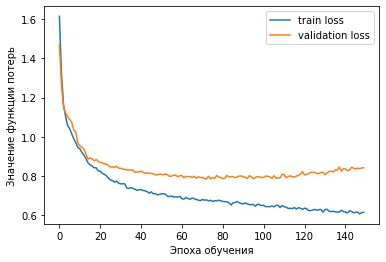

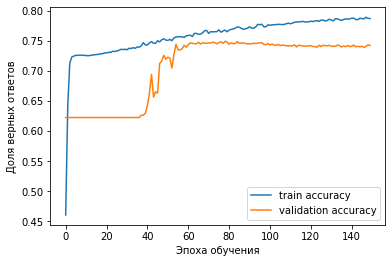

In [45]:
plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение функции потерь')
plt.legend()

plt.figure()
plt.plot(history.history[acc_name], label='train accuracy')
plt.plot(history.history[val_acc_name], label='validation accuracy')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()

plt.show()

### По сути, лучший результат получился одинаковый что при инициализации Word2Vec значениями и дообучении эмбеддингов, что без инициализации, но при инициализации Word2Vec расхождение между train и valid значительно меньше